# Day 08. Exercise 03
# Overfitting

## 0. Imports

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

# Для SVM old version
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

## 1. Preprocessing

1. Read the file `dayofweek.csv` to a dataframe.
2. Using `train_test_split` with parameters `test_size=0.2`, `random_state=21` get `X_train`, `y_train`, `X_test`, `y_test`.
3. Using, for example, `value_counts()` to check if the distribution of classes is similar in train and test.
4. Use the additional parameter `stratify=` and check the distribution again, now it should be more or less similar in both datasets.

In [69]:
df = pd.read_csv("../data/dayofweek.csv")

In [70]:
X = df.drop(columns=['dayofweek'])
y = df['dayofweek']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21
)

In [72]:
print("Train distribution (no stratified):\n", y_train.value_counts(normalize=True))

Train distribution (no stratified):
 dayofweek
3    0.232196
6    0.212908
1    0.164688
5    0.160237
2    0.092730
0    0.077893
4    0.059347
Name: proportion, dtype: float64


In [73]:
print("Test distribution (no stratified):\n", y_test.value_counts(normalize=True))

Test distribution (no stratified):
 dayofweek
3    0.245562
6    0.204142
5    0.162722
1    0.153846
0    0.091716
4    0.071006
2    0.071006
Name: proportion, dtype: float64


In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y
)

In [75]:
print("Train distribution (stratified):\n", y_train.value_counts(normalize=True))

Train distribution (stratified):
 dayofweek
3    0.234421
6    0.211424
1    0.162463
5    0.160979
2    0.088279
0    0.080861
4    0.061573
Name: proportion, dtype: float64


In [76]:
print("Test distribution (stratified):\n", y_test.value_counts(normalize=True))

Test distribution (stratified):
 dayofweek
3    0.236686
6    0.210059
1    0.162722
5    0.159763
2    0.088757
0    0.079882
4    0.062130
Name: proportion, dtype: float64


## 2. Baseline models

1. Train exactly the same baseline models from the previous exercise and calculate the accuracies using the test dataset with stratification.
2. Did all the models show the similar values of the metric? Which one has the largest difference comparing the current exercise and the previous? Put the answer to the markdown cell in the end of the section.

### a. Logreg

In [77]:
logreg = LogisticRegression(random_state=21, fit_intercept=False, solver='liblinear')
logreg.fit(X_train, y_train)
acc_logreg = accuracy_score(y_test, logreg.predict(X_test))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [78]:
print("LogReg accuracy:", acc_logreg)

LogReg accuracy: 0.6153846153846154


### b. SVM

In [79]:
svc = SVC(kernel='linear', probability=True, random_state=21)
svc.fit(X_train, y_train)
acc_svc = accuracy_score(y_test, svc.predict(X_test))
print("SVC accuracy (New standart!):", acc_svc)

SVC accuracy (New standart!): 0.7159763313609467


In [80]:
svc = OneVsRestClassifier(
    LinearSVC(random_state=21)
)
svc.fit(X_train, y_train)
acc_svc = accuracy_score(y_test, svc.predict(X_test))
print("SVC (Old STANDART: LinearSVC OvR!) accuracy:", acc_svc)

SVC (Old STANDART: LinearSVC OvR!) accuracy: 0.6242603550295858


### Погрешность на уровне 0.1% скорее всего из-за версии scikit-learn, в эталоне стара версия, но чтобы установить здесь старую версию нужно и сам python3.12 изменить на 3.9 или младше +- (у SVC с linear ядром оптимизация идёт через метод SMO (один против одного), а у LinearSVC через liblinear (один против всех).)

### c. Decision tree

In [81]:
dt = DecisionTreeClassifier(max_depth=4, random_state=21)
dt.fit(X_train, y_train)
acc_dt = accuracy_score(y_test, dt.predict(X_test))
print("Decision Tree accuracy:", acc_dt)

Decision Tree accuracy: 0.5295857988165681


### d. Random forest

In [82]:
rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
rf.fit(X_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(X_test))
print("Random Forest accuracy:", acc_rf)

Random Forest accuracy: 0.9289940828402367


## result
| Model name                  | **Old**              | **New**              |
|-----------------------------|----------------------|----------------------|
| Logistic regression accuracy| 0.6405693950177936   | 0.6153846153846154   |
| SVC accuracy (best kernel)  | 0.6126927639383155   | 0.6242603550295858   |
| Decision Tree accuracy      | 0.5516014234875445   | 0.5295857988165681   |
| Random Forest accuracy      | 0.9994068801897983   | 0.9289940828402367   |

- Все baseline модели на тесте показали схожие accuracy, но с меньшими значениями, чем в предыдущем упражнении.
- Самое большое падение качества показала модель **Random Forest**.
- Лучшая модель **Random Forest**

## 3. Crossvalidation

We could play with parameters of the model trying to achive a better accuracy on the test dataset, but it is a bad practice. It leads us again to overfitting. Test dataset is only for checking quality of a final model.

But there is another way of solving the problem – crossvalidation. It does not use test dataset, but creates one more split of train dataset. Again, there are different ways of doing it, but the common thing is that there is a validation dataset that is used for hyperparameters optimization.

1. Using `cross_val_score` with `cv=10` calculate the mean accuracy and standard deviation for every model that you used before (logreg with `solver='liblinear'`, SVC, decision tree, random forest).

### a. Logreg

In [83]:
def evaluate_cv(model, X, y, name):
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")
    return scores

In [84]:
evaluate_cv(LogisticRegression(random_state=21, fit_intercept=False, solver='liblinear'), X_train, y_train, "LogReg")

LogReg: mean=0.5816, std=0.0253


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass c

array([0.56296296, 0.61481481, 0.59259259, 0.60740741, 0.55555556,
       0.57777778, 0.61481481, 0.53333333, 0.58208955, 0.57462687])

### b. SVM

In [85]:
evaluate_cv(SVC(kernel='linear', probability=True, random_state=21), X_train, y_train, "SVC")

SVC: mean=0.6587, std=0.0436


array([0.65925926, 0.75555556, 0.62222222, 0.65185185, 0.65185185,
       0.64444444, 0.72592593, 0.62222222, 0.61940299, 0.63432836])

### c. Decision tree

In [86]:
evaluate_cv(DecisionTreeClassifier(max_depth=4, random_state=21), X_train, y_train, "Decision Tree")

Decision Tree: mean=0.5089, std=0.0319


array([0.48148148, 0.52592593, 0.47407407, 0.52592593, 0.57037037,
       0.51111111, 0.5037037 , 0.48888889, 0.54477612, 0.46268657])

### d. Random forest

In [87]:
evaluate_cv(RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21), X_train, y_train, "Random Forest")

Random Forest: mean=0.9177, std=0.0216


array([0.9037037 , 0.96296296, 0.8962963 , 0.94074074, 0.91851852,
       0.8962963 , 0.92592593, 0.8962963 , 0.93283582, 0.90298507])

## 4. Optimization

1. Choose the best model and play a little bit with the parameters on cross-validation, find a good enough parameter or a combination of the parameters.
2. Calculate the accuracy for the final model on the test dataset.
3. Draw a plot that displays the top-10 most  important features for that model.
4. Save the model using `joblib`.
5. Load the model, make predictions for the test dataset and calculate the accuracy.

In [88]:
best_rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
best_rf.fit(X_train, y_train)
acc_final = accuracy_score(y_test, best_rf.predict(X_test))
print("Final Random Forest accuracy:", acc_final)

Final Random Forest accuracy: 0.9289940828402367


In [89]:
def plot_feature_importance(importances, feature_names, top_n=10, title="Feature importance"):
    idx = np.argsort(importances)[-top_n:]
    plt.barh(range(top_n), importances[idx], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in idx])
    plt.title(title)
    plt.show()

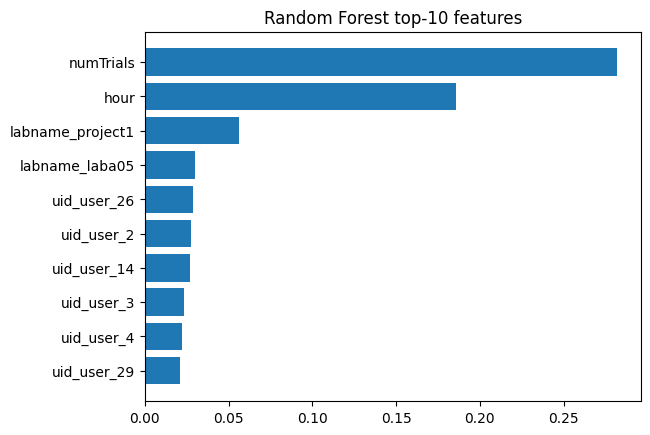

In [90]:
plot_feature_importance(best_rf.feature_importances_, X.columns, top_n=10, title="Random Forest top-10 features")

In [91]:
path = "../data/final_rf_model.pkl"
joblib.dump(best_rf, path)
print(f"Model is saved in {path}")

Model is saved in ../data/final_rf_model.pkl


In [92]:
loaded_model = joblib.load(path)

In [93]:
acc_loaded = accuracy_score(y_test, loaded_model.predict(X_test))

In [94]:
print("Loaded model accuracy:", acc_loaded)

Loaded model accuracy: 0.9289940828402367
